*05 Aug 2025, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 5303 "AI and Machine Learning in Ocean Science" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/OCES5303_ML_ocean) page.

---------------------------
# Some notes about the Argo data

In the pieces of code below I have done some minor tidying up for you.

If you want you don't have to do the global ocean, could just focus on one of the basins to keep the data size down. Would suggest Atlantic, but you can choose others if you want (or even do global ocean). 

**Possible things to investigate and do with this data**:

* Provide a brief overview of the Argo program and describe the data.
* What do the variables and parameters mean?
* Make sure the graphs you use are labelled, has a background grid, adjust the fontsize so it is readable etc.
* Predict salinity from temperature or vice-versa. Does depth matter here?
* Should you label/cluster by geographical location or by watermass properties? (You may or may not want to include depth there accordingly).
* Identify clusters then use that for regression? Does that improve on skill than if you just throw all the data in?
* Dimension reduction, then cluster, then do regression?
* Interface plotting with Cartopy?

---

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# data is slightly out-of-date and will fail with "consolidated" option but will load
# silencing the warning
ds = xr.open_zarr("./GLOB_HOMOGENEOUS_variables.zarr/", consolidated=False)
ds

<xarray.Dataset> Size: 626MB
Dimensions:    (N_PROF: 128910, DEPTH: 302)
Coordinates:
  * DEPTH      (DEPTH) float32 1kB 0.0 -5.0 -10.0 ... -1.5e+03 -1.505e+03
    LONGITUDE  (N_PROF) float32 516kB dask.array<chunksize=(67010,), meta=np.ndarray>
    LATITUDE   (N_PROF) float32 516kB dask.array<chunksize=(67010,), meta=np.ndarray>
    TIME       (N_PROF) datetime64[ns] 1MB dask.array<chunksize=(64455,), meta=np.ndarray>
Dimensions without coordinates: N_PROF
Data variables:
    PSAL       (N_PROF, DEPTH) float32 156MB dask.array<chunksize=(67010, 302), meta=np.ndarray>
    TEMP       (N_PROF, DEPTH) float32 156MB dask.array<chunksize=(67010, 302), meta=np.ndarray>
    DBINDEX    (N_PROF) float64 1MB dask.array<chunksize=(67010,), meta=np.ndarray>
    SIG0       (N_PROF, DEPTH) float32 156MB dask.array<chunksize=(67010, 302), meta=np.ndarray>
    BRV2       (N_PROF, DEPTH) float32 156MB dask.array<chunksize=(67010, 302), meta=np.ndarray>
Attributes:
    Title:             VENTHSAL-IA
    conventions:       CF-1.6
    conventions_help:  http://cf-pcmdi.llnl.gov/documents/cf-conventions/1.6/...
    createdBy:         gmaze
    createdWith:       /home8/homedir3/perso/gmaze/work/Projects/GMM/Argo-pro...
    creationDate:      2019/01/22 22:07:00
    dataset_file:      /home8/homedir3/perso/gmaze/data/ARGO/copoda_db/setup_...
    institution:       LPO/Ifremer
    long_title:        Argo subset of plain profiles for VENTHSAL-IA
    source:            VENTHSAL-Argo
    subset_ID:         1-2
    subset_maxnumber:  3.0

In [2]:
# subset some data out (only select T and S, and ones with sensible S)

# NOTE (JM Apr 15): if it complains about no indexing by booleans, try adding the .compute() bit in as below
# da_s  = da_al.where(((da_al.PSAL <40.) & (da_al.PSAL>25.)).compute(), drop=True)

da_al = ds[["PSAL", "TEMP", "DEPTH"]] # (DEPTH: 302, N_PROF: 128910)
da_s  = da_al.where(((da_al.PSAL <40.) & (da_al.PSAL>25.)).compute(), drop=True)
da_s  = da_s.dropna('N_PROF')
da_s

<xarray.Dataset> Size: 313MB
Dimensions:    (N_PROF: 128904, DEPTH: 302)
Coordinates:
  * DEPTH      (DEPTH) float32 1kB 0.0 -5.0 -10.0 ... -1.5e+03 -1.505e+03
    LONGITUDE  (N_PROF) float32 516kB -178.5 -178.5 -178.6 ... 179.5 179.4 179.5
    LATITUDE   (N_PROF) float32 516kB -62.17 -62.71 -62.28 ... 58.08 58.7 58.96
    TIME       (N_PROF) datetime64[ns] 1MB 2009-01-05T08:36:05.624999936 ... ...
Dimensions without coordinates: N_PROF
Data variables:
    PSAL       (N_PROF, DEPTH) float32 156MB dask.array<chunksize=(64454, 302), meta=np.ndarray>
    TEMP       (N_PROF, DEPTH) float32 156MB dask.array<chunksize=(64454, 302), meta=np.ndarray>
Attributes:
    Title:             VENTHSAL-IA
    conventions:       CF-1.6
    conventions_help:  http://cf-pcmdi.llnl.gov/documents/cf-conventions/1.6/...
    createdBy:         gmaze
    createdWith:       /home8/homedir3/perso/gmaze/work/Projects/GMM/Argo-pro...
    creationDate:      2019/01/22 22:07:00
    dataset_file:      /home8/homedir3/perso/gmaze/data/ARGO/copoda_db/setup_...
    institution:       LPO/Ifremer
    long_title:        Argo subset of plain profiles for VENTHSAL-IA
    source:            VENTHSAL-Argo
    subset_ID:         1-2
    subset_maxnumber:  3.0

In [3]:
# pre-define some regions based on geographical location

# global ocean
# da = da_s

# Atlantic sector
da = da_s.where((da_s['LONGITUDE'] >-75.) & (da_s['LONGITUDE']<17), drop= True)

# Southern Ocean, split into a few sectors
# da  = da_s.where(da_s['LATITUDE'] <=  -56., drop=True)
# da_1 = da_s.where((da_s['LATITUDE'] > -56.) & (da_s['LATITUDE'] <= -40.) , drop=True)

# North Atlantic
# da = da_s.where(  (da_s['LATITUDE']  >   0.) 
#                 & (da_s['LATITUDE']  <= 50.) 
#                 & (da_s['LONGITUDE'] > -78.) 
#                 & (da_s['LONGITUDE'] <  31.),
#                 drop=True)

# Make up your own if you want

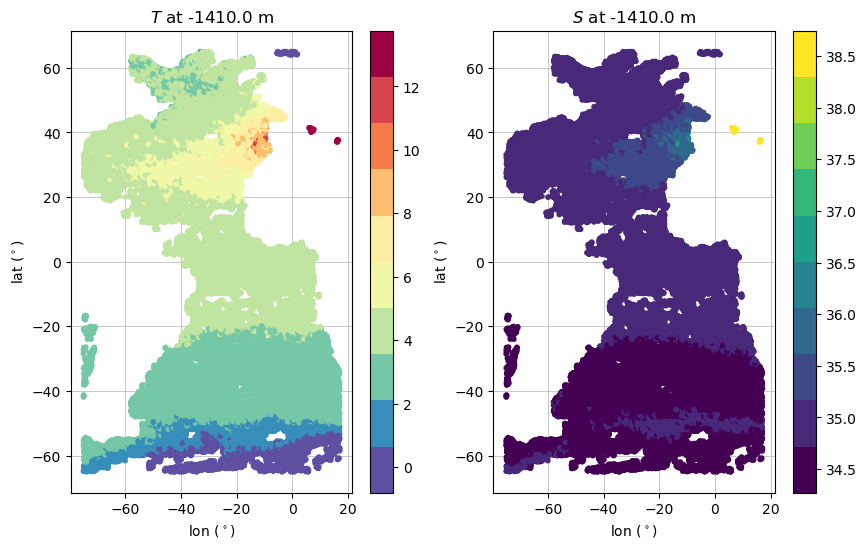

In [4]:
# plot temperature and salnity at fixed depth only in Atlantic sector

nl = -20

fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 2, 1)
cs = ax.scatter(da.LONGITUDE, da.LATITUDE, 10, da.TEMP[:, nl],
                cmap = plt.get_cmap('Spectral_r', 10), zorder=3)
ax.set_xlabel(r"lon ($^\circ$)")
ax.set_ylabel(r"lat ($^\circ$)")
ax.set_title(f"$T$ at {da_s.DEPTH[nl].values} m")
plt.colorbar(cs)
ax.grid(lw=0.5, zorder=0)

ax = plt.subplot(1, 2, 2)
cs = ax.scatter(da.LONGITUDE, da.LATITUDE, 10, da.PSAL[:, nl],
                cmap = plt.get_cmap('viridis', 10), zorder=3)
ax.set_xlabel(r"lon ($^\circ$)")
ax.set_ylabel(r"lat ($^\circ$)")
ax.set_title(f"$S$ at {da_s.DEPTH[nl].values} m")
plt.colorbar(cs)
ax.grid(lw=0.5, zorder=0)

In [5]:
# remove deeper parts of data, create data array as (profile, depth, features)

data = np.stack((da.TEMP[:, :-30].values, da.PSAL[:, :-30].values), axis=2)
print(f"data has shape {data.shape}")

depth = da_s.DEPTH[:-30].values  # this only has dimension of DEPTH

data has shape (32886, 272, 2)


Text(0.5, 0.98, 'vertical profile at Lon = -47.66$^\\circ$,Lat = 41.88$^\\circ$')

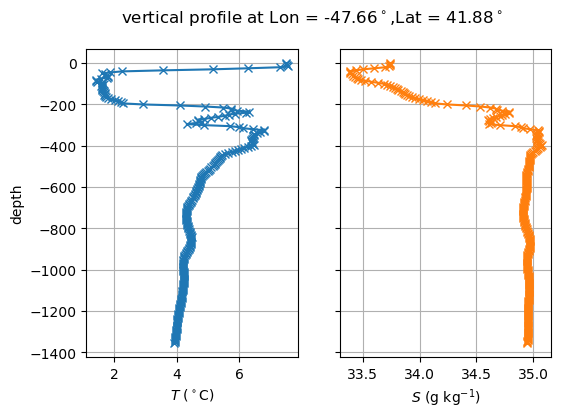

In [6]:
# plot a vertical profile

# randomly select a profile (ind = 17874 is a good stable one)
ind = np.random.randint(data.shape[0])

fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(1, 2, 1)
ax.plot(data[ind, :, 0], depth, "C0-x")
ax.set_ylabel("depth")
ax.set_xlabel(r"$T$ (${}^\circ\mathrm{C}$)")
ax.grid()

ax = plt.subplot(1, 2, 2)
ax.plot(data[ind, :, 1], depth, "C1-x")
ax.set_xlabel(r"$S$ ($\mathrm{g}\ \mathrm{kg}^{-1})$")
ax.set_yticklabels([])
ax.grid()

plt.suptitle(f"vertical profile at Lon = {da.LONGITUDE[ind].values:.2f}$^\circ$,\
Lat = {da.LATITUDE[ind].values:.2f}$^\circ$")